In [110]:
import numpy as np 
import matplotlib.pyplot as plt
import os
import gymnasium as gym 
from collections import defaultdict
import copy

In [111]:
env = gym.make('CliffWalking-v0')

In [112]:
def epsilon_greedy(env,Q,epsilon):
  def policy(state):
    if state not in Q:
      return np.random.choice(env.action_space.n)
    else:
      if np.random.rand() < epsilon:
        return np.random.choice(env.action_space.n)
      else:
        return np.argmax(Q[state])
  return policy

In [113]:
numeps = 1000
epsilon = 0.1
alpha = 0.1
gamma = 1.0

In [114]:
def deterministic_greedy(Q):
  def policy(state):
    return np.argmax(Q)
  return policy

In [115]:
def sumQ(Q1, Q2):
  # More efficient dictionary merging
  Q = defaultdict(lambda: np.zeros(Q1[next(iter(Q1))].shape))
  for key in set(Q1.keys()) | set(Q2.keys()):
    Q[key] = Q1[key] + Q2[key]
  return Q

In [116]:
def double_qlearning(env,numeps,epsilon,alpha,gamma):
  action_space_n = env.action_space.n
  Q1 = defaultdict(lambda: np.zeros(action_space_n, dtype=np.float32))
  Q2 = defaultdict(lambda: np.zeros(action_space_n, dtype=np.float32))
  policy = epsilon_greedy(env,sumQ(Q1,Q2),epsilon)
  
  
  for i in range(1,numeps+1):
    if i % 1000  == 0:
      print(f'episode = {i}')
    
    
    state, _ = env.reset()
    done = False
    
    while not done:
      action = policy(state)
      tup = env.step(action)
      next_state, reward, terminated, truncated = tup[0], tup[1], tup[2], tup[3]
      done = terminated or truncated
      flag = np.random.choice([0,1])
      if flag:#bootstrap using action values from Q2 but the action is greedy over q1 
        action_greedy = np.argmax(Q1[next_state])
        Q1[state][action] = Q1[state][action] + alpha*(reward + gamma*Q2[next_state][action_greedy] - Q1[state][action])
      else:#bootstrap using action values from Q1 but the action is greedy over q2
        action_greedy = np.argmax(Q2[next_state])
        Q2[state][action] = Q2[state][action] + alpha*(reward + gamma*Q1[next_state][action_greedy] - Q2[state][action])
      state = next_state
      
  Q = sumQ(Q1,Q2)
    
  return lambda state:np.argmax(Q[state]), Q

In [117]:
policy, Q = double_qlearning(env,numeps,epsilon,alpha,gamma)

episode = 1000


In [118]:
print(Q)

defaultdict(<function sumQ.<locals>.<lambda> at 0x7f68500189d0>, {0: array([-29.999924, -27.999931, -27.999931, -29.999924], dtype=float32), 1: array([-27.999931, -25.999939, -25.999939, -29.999924], dtype=float32), 2: array([-25.999939, -23.999947, -23.999947, -27.999931], dtype=float32), 3: array([-23.999947, -21.999954, -21.999954, -25.999939], dtype=float32), 4: array([-21.999954, -19.999962, -19.999962, -23.999947], dtype=float32), 5: array([-19.999962, -17.99997 , -17.99997 , -21.999954], dtype=float32), 6: array([-17.99997 , -15.999979, -15.999979, -19.999962], dtype=float32), 7: array([-15.999979, -13.999983, -13.999983, -17.99997 ], dtype=float32), 8: array([-13.999983, -11.999987, -11.999987, -15.999979], dtype=float32), 9: array([-11.999987,  -9.99999 ,  -9.99999 , -13.999983], dtype=float32), 10: array([ -9.99999  ,  -7.9999943,  -7.9999943, -11.999987 ], dtype=float32), 11: array([-7.9999943, -7.9999943, -5.999996 , -9.99999  ], dtype=float32), 12: array([-29.999924, -25.9

''' 
FUNCTION plot_cliff_path:
    1. Setup Constants
       - grid is 4x12
       - start = 36, goal = 47
       - cliffs = positions 37-46

    2. Basic Plot Setup
       - create 12x4 figure
       - set grid = True
       - set axes: x(-0.5 to 11.5), y(3.5 to -0.5)
       - set ticks: x(0-11), y(0-3)

    3. Draw Fixed Elements
       - for each cliff position (37-46):
           put 'C' at (pos % 12, pos // 12)
       - put 'S' at start position (36 % 12, 36 // 12)
       - put 'G' at goal position (47 % 12, 47 // 12)

    4. Draw Path
       - reset environment
       - while not done:
           - if current != start and != goal:
               put 'o' at (state % 12, state // 12)
           - get next state using policy
           - update done condition

    5. Show plot
    
    
    Key things to remember:

  Grid conversion: position to (x,y) is always (pos % 12, pos // 12)

  Fixed positions: start=36, goal=47, cliffs=37-46
  
  Plot elements are: 'C'=cliff, 'S'=start, 'G'=goal, 'o'=path

  Axes need both limits (-0.5 to max+0.5) and ticks (0 to max)

'''

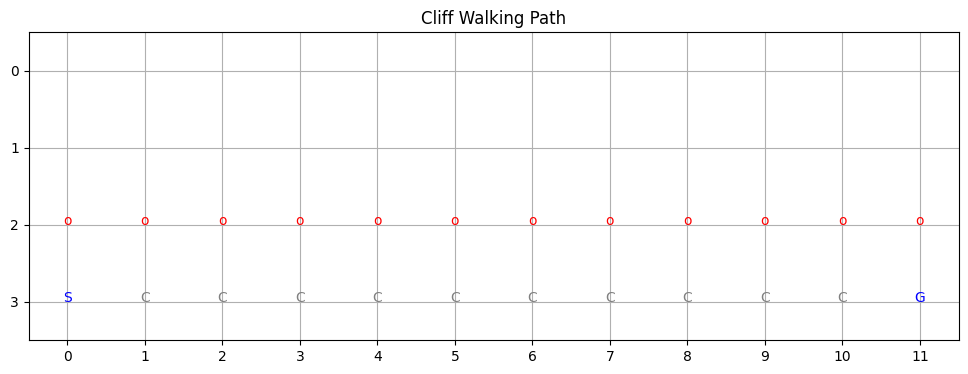

In [122]:
def plot_cliff_path(Q, env, policy):
    # Grid dimensions
    rows, cols = 4, 12
    start, goal = 36, 47
    
    # Setup plot
    plt.figure(figsize=(12, 4))
    
    # Draw grid
    plt.grid(True)
    plt.xlim(-0.5, cols - 0.5)
    plt.ylim(rows - 0.5, -0.5)
    plt.xticks(range(cols))
    plt.yticks(range(rows))
    
    # Draw cliffs
    for cliff in range(37, 47):
        r, c = cliff // cols, cliff % cols
        plt.text(c, r, 'C', ha='center', color='gray')
    
    # Draw start and goal
    plt.text(start % cols, start // cols, 'S', ha='center', color='blue')
    plt.text(goal % cols, goal // cols, 'G', ha='center', color='blue')
    
    # Draw optimal path
    state, _ = env.reset()
    done = False
    
    while not done:
        r, c = state // cols, state % cols
        
        # Don't mark start and goal with dots
        if state != start and state != goal:
            plt.text(c, r, 'o', ha='center', color='red')
            
        action = policy(state)
        next_state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
    
    plt.title("Cliff Walking Path")
    plt.show()
    
plot_cliff_path(Q, env, policy)
    
